# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Package Install

In [1]:
# !pip install missingno
# !pip install -U ppscore

In [1]:
# import libraries

# Data Wrangling
import pandas                   as pd
import numpy                    as np
import pyspark
from pyspark                    import SparkConf
from pyspark.sql                import SparkSession, Window
from pyspark.sql.functions      import isnan, when, count, col, isnull, udf, last, \
                                       first, struct, lit, approx_count_distinct, from_unixtime, \
                                    month, datediff, first, year, concat, substring,max as Fmax

from pyspark.sql import functions as F
from pyspark.sql.types          import IntegerType, DoubleType, StringType, TimestampType, DateType, LongType
from pyspark.ml.feature         import StringIndexer, VectorAssembler

# Machine Learning
from pyspark.ml.classification  import LogisticRegression
from pyspark.ml.classification  import RandomForestClassifier
from pyspark.ml.classification  import GBTClassifier
from pyspark.ml.classification  import LinearSVC
from pyspark.ml.classification  import DecisionTreeClassifier
from pyspark.ml.classification  import NaiveBayes
from pyspark.ml.evaluation      import MulticlassClassificationEvaluator
from pyspark.ml.tuning          import CrossValidator, ParamGridBuilder
from pyspark.ml.feature         import StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml                 import Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, IndexToString
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import *
from pyspark.ml.tuning import CrossValidatorModel
 

# Visualizations
from matplotlib.ticker          import PercentFormatter
import matplotlib.pyplot        as plt
import seaborn                  as sns

# Miscellaneous 
from datetime                   import datetime
from datetime                   import timedelta


In [5]:
from pyspark.sql import SparkSession
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# As suggested at 
# https://stackoverflow.com/questions/38417441/pyspark-socket-timeout-exception-after-application-running-for-a-while
# increase Spark heartbeatInterval to prevent session from "dying"
spark.conf.set("spark.executor.heartbeatInterval","72000s")

In [6]:
import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.private.eu.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-2883ceeb-79f1-4ed1-ba7c-55082a31f234',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'Nx6645ynb4Ks-nu-tcKIBitbut6oF66sH6NpbyoryMYQ'
}

configuration_name = 'os_31f69f40fbb04918bbc97f1735d90954_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('mini_sparkify_event_data.json', 'churnpredictionfinalruns-donotdelete-pr-3qwjzhczxobapc'))
# df_data_1.take(5)
# Load and Clean Dataset
#In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# As suggested at 
# https://stackoverflow.com/questions/38417441/pyspark-socket-timeout-exception-after-application-running-for-a-while
# increase Spark heartbeatInterval to prevent session from "dying"
spark.conf.set("spark.executor.heartbeatInterval","72000s")

# Load data
# Read the dataframe
df_full = spark.read.json('mini_sparkify_event_data.json')
df = df_full.sample(fraction=0.1, seed=3)
df.take(5)

[Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Time For Miracles', status=200, ts=1538352394000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Stan Mosley', auth='Logged In', firstName='Colin', gender='M', itemInSession=57, lastName='Freeman', length=246.69995, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registratio

In [8]:
# Display data schema to get an idea of what the data looks like
# df.printSchema()

In [9]:
# # Counts
# print(f'Total No. of records: {df.count()}')
# print(f'Total No. of Columns: {len(df.columns)}')
# print(f'No. of unique users: {df.select("userId").distinct().count()}')

In [10]:
# # Check of Null's - Examine nature of creation for those nulls
# nulls_check = pd.DataFrame(df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).collect(),
#                            columns = df.columns).transpose()
# nulls_check.columns = ['Null Values']
# nulls_check

In [11]:
# import missingno as msno
# %matplotlib inline
# df_pandas = df.toPandas()
# msno.heatmap(df_pandas)

In [12]:
# import seaborn as sns
# plt.figure(figsize=(10,6))
# sns.heatmap(df_pandas.isnull(), cbar=False)

From the above count, we observe that:

1. There is missing information for users not logged in, corresponding to empty userID.
2. There are a lot of missing values in song, length, artist columns which may correspond to the events where the user is not listening to music.

## Clean dataset

In [13]:
def clean_data(df):
    '''
    Function which performs basic data cleaning.
    
    INPUT: 
    df - pyspark dataframe containing user events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column and duplicates if any
    '''
    
    # remove rows where userId is empty and duplicated rows
    df_clean = df.filter(df["userId"] != "").dropDuplicates()

    return df_clean

# Remove empy and duplicated records.
df_clean = clean_data(df)

# print out first line
df_clean.head()

Row(artist='Slim Dusty', auth='Logged In', firstName='Sebastian', gender='M', itemInSession=17, lastName='Wang', length=198.922, level='free', location='Jackson, MS', method='PUT', page='NextSong', registration=1538050164000, sessionId=52, song='Long Black Road', status=200, ts=1538422228000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='53')

## Type Casting 

In [14]:
# convert string timestamp to date 

def get_date_from_timestamp(df, col_name, new_col_name):
    return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))

# convert event timestamp
df_clean = get_date_from_timestamp(df_clean, 'ts', 'ts_date')

# convert registration timestamp
df_clean = get_date_from_timestamp(df_clean, 'registration', 'registration_date')

df_clean.head()

Row(artist='Slim Dusty', auth='Logged In', firstName='Sebastian', gender='M', itemInSession=17, lastName='Wang', length=198.922, level='free', location='Jackson, MS', method='PUT', page='NextSong', registration=1538050164000, sessionId=52, song='Long Black Road', status=200, ts=1538422228000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='53', ts_date='2018-10-01 19:30:28', registration_date='2018-09-27 12:09:24')

In [15]:
# # time period for all events in dataset
# df_clean.groupBy(year('registration_date'), month('registration_date')).count().sort(month('registration_date')).show()

In [16]:
# # time period for all events in dataset
# df_clean.groupBy(year('ts_date'), month('ts_date')).count().sort(month('ts_date')).show()

From the above count, we observe that:

1. The registrations at the service in the sepcific dataset happened between March & November.
2. Most of the events in the dataset happened between October and November 2018.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
# gender_interaction_df = df.groupBy('gender').count().toPandas()
# gender_interaction_df['count'] = gender_interaction_df['count']/df.count()
# gender_interaction_df.plot.bar(x = 'gender', color = sns.color_palette()[0], legend = None)
# sns.set(style="ticks")
# sns.despine(right=True,top=True)
# plt.xlabel('Gender')
# plt.ylabel('Share of Interactions')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.savefig('sparkify_gender_interaction.png', dpi = 300)
# plt.show()

In [18]:
# # Look at gender distribution by user, i.e. how many users identified as male, female or did not provide an answer?
# auth_df = df.groupBy(['auth']).count().toPandas()
# auth_df = auth_df['auth'].value_counts(normalize = True, dropna = False)
# auth_df.plot.bar(x=auth_df.index, color = sns.color_palette()[0])
# sns.set(style="ticks")
# sns.despine(right=True,top=True)
# plt.xlabel('Proportion')
# plt.ylabel('Share of Users')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.savefig('sparkify_auth_types.png', dpi = 300)
# plt.show()

In [19]:
# # Look at gender distribution by user, i.e. how many users identified as male, female or did not provide an answer?
# level_df = df.groupBy(['level']).count().toPandas()
# level_df = level_df['level'].value_counts(normalize = True, dropna = False)
# level_df.plot.bar(x=level_df.index, color = sns.color_palette()[0])
# sns.set(style="ticks")
# sns.despine(right=True,top=True)
# plt.xlabel('Users')
# plt.ylabel('Proportion')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.savefig('sparkify_level_types.png', dpi = 300)
# plt.show()

In [20]:
# # Descriptive statistics with regards to all user interactions history
# interactions_df = df.groupBy('userId').count().toPandas()
# interactions_df.plot.hist(sns.color_palette()[0], legend = None)
# plt.xlabel('Number of Interactions')
# sns.set(style="ticks")
# sns.despine(right=True,top=True)
# plt.savefig('sparkify_num_interactions.png', dpi = 300)

# print('Median number of interactions per user: {}'.format(interactions_df['count'].median()))
# print('Standard deviation of interactions per user: {}'.format(interactions_df['count'].std()))
# print('Minimum number of interactions for a single user: {}'.format(interactions_df['count'].min()))
# print('Maximum number of interactions for a single user: {}'.format(interactions_df['count'].max()))

In [21]:
# num_users = df_clean.select('userId').distinct().count()
# print(f'There are {df_clean.count()} events recorded in the small subset of data generated by {num_users} unique users.')

## Define Churn

In [22]:
# Create column Churn when the event recorded is 'Cancellation Confirmation'. 

# A value equal to 1 indicates that the user cancelled the subscription.
churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())

df_clean = df_clean.withColumn("churn_cancellation", churn_cancellation("page"))
df_clean.where(df_clean['churn_cancellation']==1).head(1)

cancelled_users = df_clean.select(['userId']).where(df_clean.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values
print(f'There are {len(cancelled_users)} users that cancelled the subscription.')
# set column 'churn_cancellation' to 1 for all rows for cancelled_users

df_clean = df_clean.withColumn('churn_cancellation', when((df_clean.userId).isin(list(cancelled_users)), 1).otherwise(0))

# Show counts per value for 'churn_cancellation'
df_clean.groupBy('churn_cancellation').count().show()

There are 5 users that cancelled the subscription.
+------------------+-----+
|churn_cancellation|count|
+------------------+-----+
|                 1|  481|
|                 0|27069|
+------------------+-----+



## Sanity Check for some users

In [23]:
# print(list(cancelled_users))
# # show all events related to a churned user
# df_clean.select(['firstName', 'level', 'method', 'page', 'ts_date','churn_cancellation']).where(df_clean.userId == '129').toPandas().head(n=5)
# df_clean.select(['firstName', 'level', 'method', 'page', 'ts_date','churn_cancellation']).where(df_clean.userId == '99').toPandas().head(n=5)

In [24]:
# num_active_users = df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
# print(f'There are {num_active_users} active users and {len(cancelled_users)} users who cancelled the subscription.')

## Chrun Rate: Gender Comparison

In [25]:
# # calculate the number of female and male users
# male = df_clean.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
# female = df_clean.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))

# print(f'There are {male.collect()[0]["count(count)"]} male and {female.collect()[0]["count(count)"]} female users in the dataset.')
      
# male_churned_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'gender').count().count() * 100
# print(f'{round(male_churned_perc)}% of users who churned are male.')
      
# male_active_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'gender').count().count() * 100
# print(f'{round(male_active_perc)}% of users who are active are male.')
      
# female_active_perc = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'gender').count().count() * 100
# print(f'{round(female_active_perc)}% of users who are active are female.')
      
# female_users_churned_perc = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100
# print(f'Among female users {round(female_users_churned_perc)}% churned.')
      
# male_users_churned_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100
# print(f'Among male users {round(male_users_churned_perc)}% churned.')

From the above comparison, we observe that:

1. There are more male users (121) than female users (104).
2. Most of the users who have churned are male (62%).
3. Among female users 19% have churned, while among male users 26% have churned.
4. Female users seem to be more active. They have generated 56% of the events.
5. Female users who churned generated fewer events than male users who churned.

## Chrun Rate: Plan Comparison

In [26]:
# # calculate the number of paid and free accounts

# paid = df_clean.select('userId', 'level').where(df_clean.level == 'paid').groupBy('userId').count().agg(count("count"))
# free = df_clean.select('userId', 'level').where(df_clean.level == 'free').groupBy('userId').count().agg(count("count"))

# print(f'There are {paid.collect()[0]["count(count)"]} paid and {free.collect()[0]["count(count)"]} free plan accounts in dataset.')
      
# paid_churned = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'level').count().count() * 100
# print(f'{round(paid_churned)}% of churned users were on a paid plan.')
      
# paid_active = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'level').count().count() * 100
# print(f'{round(paid_active)}% of active users are on a paid plan.')

From the above comparison, we observe that:

1. There is not a big difference between active and cancelled users in terms of the proportion of paid subscription plans. Overall, there are more free subscriptions than paid ones.

## Churn Rate: Location Comparison

In [27]:
# Create column 'city'
df_clean = df_clean.withColumn("temp_city", F.split(df_clean.location, ',').getItem(0))
df_clean = (df_clean.withColumn("city", F.split(df_clean.temp_city, '-').getItem(0)) 
                    .drop('temp_city'))

# Create column 'state'
df_clean = df_clean.withColumn("state", substring(df_clean.location, -2, 2))

# Create column with last location of the user
# w = Window.partitionBy('userId')
# df_clean = df_clean.withColumn('last_ts', max('ts_date').over(w))
# df_clean = df_clean.withColumn('last_city', when(df_clean.last_ts == df_clean.ts_date, df_clean.city))
# df_clean = df_clean.withColumn('last_state', when(df_clean.last_ts == df_clean.ts_date, df_clean.state))

In [28]:
df_location = df_clean.select('userId','churn_cancellation', 'city', 'state').toPandas()
df_location_pd = df_location.groupby(['userId', 'state']).mean().reset_index()

In [29]:
# # Plot distribution of events by state
# plt.figure(figsize=(12,8))

# x, y, hue = 'state', 'proportion', 'churn_cancellation'
# hue_order = ['Active users', 'Churned users']

# (df_location[x]
#  .groupby(df_location[hue])
#  .value_counts(normalize=True)
#  .rename(y)
#  .reset_index()
#  .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

# plt.legend(loc='upper right', title='Churn')
# plt.title('Location Distribution of Events')
# plt.xlabel('State')
# plt.ylabel('Proportion of events')
# plt.xticks(rotation=90)
# plt.show()

From the above comparision we observe that:

1. It appears to be differences in the distribution between active and churned users across states. In addition, there are some states that have no churned users (e.g.New Hampshire), and some states that have only churned users (e.g., Arkansas, Oregon).

2. California, Pennsylvania, Texas, Florida have the most users and events for active and churned users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
from pyspark.sql.functions import *

In [31]:
def feature_explore(df):
    """
    Function that calculates the feature correlation & predictive importance
    
    INPUT:
    df - Pandas dataframe containing Sparkify events
    
    
    OUTPUT:
    Seaborn Heatmaps
    
    """
    # Check correlation among features

    # creating mask
    mask = np.triu(np.ones_like(df.corr()))

    # plotting a triangle correlation heatmap
    dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, mask=mask)
    
    
    # Check predictive importance amongst features
    matrix = pps.matrix(df)
    sns.heatmap(matrix,annot=True,fmt=".2f")
    
    
    # displaying heatmap
    plt.show()
    
    
    
def clean_data(df):
    '''
    Function that performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column and duplicates if any
    '''
    
    # remove rows where userId is empty and duplicated rows
    df_clean = df.filter(df["userId"] != "").dropDuplicates()

    return df_clean


def get_date_from_timestamp(df, col_name, new_col_name):
    '''
    Function that convert timestamp to date
    '''
    
    return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))


def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning models.
    
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning which
    contains the following columns:
    
    1. userId - initial id of the user
    2. gender - user's gender
    3. days_registered - days since user's registration
    4. last_state - current state of the user
    5. avg_songs_per_day - average songs played per day
    6. last_level - current subscription plan
    7. Thumbsup_proportion - ratio of thumbs up over thumbs down
    8. num_add_friends - number of add friends events
    9. avg_roll_adv_per_day - average number of roll adv played per day
    10. churn_cancellation
    '''
    
    # Clean dataset using clean_data function
    df = clean_data(df)
    
    # Convert event timestamp
    df = get_date_from_timestamp(df, 'ts', 'ts_date')
    
    # Convert registration timestamp
    df = get_date_from_timestamp(df, 'registration', 'registration_date')
    
    # Create column Churn when the event recorded is 'Cancellation Confirmation'. 
    # A value equal to 1 indicates that the user cancelled the subscription.
    churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    
    df = df.withColumn("churn_cancellation", churn_cancellation("page"))
    
    # Get userId with churn_cancellation == 1
    cancelled_users = df.select(['userId']).where(df.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values
    cancelled_users = list(cancelled_users)
    df = df.withColumn('churn_cancellation', when((df.userId).isin(cancelled_users), 1).otherwise(0))
    
    # Convert column gender to numeric: 1 for 'female' and 0 for 'male'
    gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
    
    df = df.withColumn("gender", gender("gender"))
    
    # Convert column level to numeric: 1 for 'paid' and 0 for 'free'
    level = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    
    #df = df.withColumn("level", level("level"))
    
    levels = df.select(['userId', 'level', 'ts_date'])\
                        .orderBy(desc('ts_date'))\
                        .dropDuplicates(['userId'])\
                        .select(['userId', 'level'])\
                        .withColumn('last_level', level('level').cast(IntegerType()))
    levels = levels.drop('level')
    levels = levels.withColumnRenamed('userId', 'level_userId')

    
    # Compute active days as number of days since registration
    # Create dataframe with last timestamp (ts_date) per user
    df_last_ts = df.groupBy('userId').agg(max('ts_date').alias('last_interaction'))
    
    # Join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
    df = df.join(df_last_ts, on='userId').select(df_last_ts['*'], df['*']).withColumn('days_registered', datediff(df_last_ts['last_interaction'], df['registration_date']).cast('float'))
    
    # Create a new column 'date' with format 'yyyy-MM-dd'
    df = df.withColumn('date', date_format('ts_date', 'yyyy-MM-dd').alias('date'))
    
    # Create a new column 'last_state' where the last session was recorded
    df = df.withColumn("state", substring(df.location, -2, 2))
    df = df.withColumn('last_state', when(df_last_ts.last_interaction == df.ts_date, df.state))
        
    # Compute average songs played by day per user
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs_per_day', avg('songs').over(w))
    songs = songs.select(songs['userId'].alias('songs_userId'), 'avg_songs_per_day')
    songs = songs.withColumn('avg_songs_per_day', F.round(songs['avg_songs_per_day'],2)).distinct()
    
    # Compute the number of thumbs up for user
    w = Window.partitionBy('userId')
    thumbs_up = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbs_up = thumbs_up.select(thumbs_up['userId'].alias('thumbsup_userId'), 'thumbs_up')
 
    # Compute the number of thumbs down per user
    w = Window.partitionBy('userId')
    thumbs_down = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbs_down = thumbs_down.select(thumbs_down['userId'].alias('thumbsdown_userId'), 'thumbs_down')
      
    # Compute the number of add friend events per user
    w = Window.partitionBy('userId')
    num_add_friend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('num_add_friend')).distinct()
    num_add_friend = num_add_friend.select(num_add_friend['userId'].alias('friends_userId'), 'num_add_friend')
    
    # Compute the fraction of page 'roll advert'
    w = Window.partitionBy('userId', 'date')
    roll_adv = df.where(df.page == 'Roll Advert').select('userId', 'date', count('userId').over(w).alias('roll_adv')).distinct()
    w = Window.partitionBy('userId')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', avg('roll_adv').over(w))
    roll_adv = roll_adv.select(roll_adv['userId'].alias('rolladv_userId'), 'avg_roll_adv_per_day')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', F.round(roll_adv['avg_roll_adv_per_day'],2)).distinct()
    
    # Construct the final dataset
    df_ml = df.select('userId', 'gender', 'churn_cancellation', 'days_registered', 'last_state').dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId, how='left').distinct() 
    df_ml = df_ml.join(levels, df_ml.userId == levels.level_userId, how='left').distinct()
    df_ml = df_ml.join(thumbs_up, df_ml.userId == thumbs_up.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbs_down, df_ml.userId == thumbs_down.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.withColumn('Thumbsup_proportion', F.round(df_ml.thumbs_up / df_ml.thumbs_down, 2))
    df_ml = df_ml.fillna(0, subset=['Thumbsup_proportion'])
    df_ml = df_ml.join(num_add_friend, df_ml.userId == num_add_friend.friends_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['num_add_friend'])
    df_ml = df_ml.join(roll_adv, df_ml.userId == roll_adv.rolladv_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['avg_roll_adv_per_day'])
    df_ml = df_ml.drop('thumbs_up', 'thumbs_down', 'songs_userId', 'level_userID', 'rolladv_userId', 'thumbsup_userId', 'thumbsdown_userId', 'friends_userId')

    return df_ml

# mini_sparkify_event_data = 'mini_sparkify_event_data.json'
# df = spark.read.json(cos.url('mini_sparkify_event_data.json', 'churnpredictionfinalruns-donotdelete-pr-3qwjzhczxobapc'))
# df.persist()

df_ml = prepare_dataset(df)   

## Feature Correlation & Predictive Importance

In [32]:
# feature_explore(df_ml.toPandas())

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [33]:
# Model Evaluator User Defined Functions
def udfModelEvaluator(dfPredictions, labelColumn='label'):

    colSelect = dfPredictions.select(
      [F.col('prediction').cast(DoubleType())
       ,F.col(labelColumn).cast(DoubleType()).alias('label')])

    metrics = MulticlassMetrics(colSelect.rdd)

    mMatrix = metrics.confusionMatrix().toArray().astype(int)    

    mTP = metrics.confusionMatrix().toArray()[1][1]
    mTN = metrics.confusionMatrix().toArray()[0][0]
    mFP = metrics.confusionMatrix().toArray()[0][1]
    mFN = metrics.confusionMatrix().toArray()[1][0]
    
    mAccuracy = metrics.accuracy
    mPrecision = mTP / (mTP + mFP)
    mRecall = mTP / (mTP + mFN)
    mF1 = metrics.fMeasure(1.0)

    mResults = [mAccuracy, mPrecision, mRecall, mF1, mMatrix, mTP, mTN, mFP, mFN, "Return [[0]=Accuracy, [1]=Precision, [2]=Recall, [3]=F1, [4]=ConfusionMatrix, [5]=TP, [6]=TN, [7]=FP, [8]=FN]"]

    return mResults

In [34]:
# split into train and test sets (80% - 20%)

df_ml = df_ml.withColumnRenamed("churn_cancellation", "label")

train, test = df_ml.randomSplit([0.8, 0.2], seed = 42)

# Count users by label in train set

counts_train = train.groupBy('label').count().toPandas()
print(counts_train)

   label  count
0      1      5
1      0    185


In [35]:
# Taking 70% of both 0's and 1's into training set
train = df_ml.sampleBy("label", fractions={0: 0.7, 1: 0.7}, seed=10)
test = df_ml.subtract(train)

In [36]:
# train.groupBy("label").count().show()

In [37]:
# test.groupBy("label").count().show()

In [38]:
# Counts

count_churned = counts_train[counts_train['label']==1]['count'].values[0]
count_total = counts_train['count'].sum()

# Weights

c = 2 # number of labels
weight_churned = count_total / (c * count_churned)
weight_no_churned = count_total / (c * (count_total - count_churned))

# Create a new column 'weight' containing a weight for each observation according to its class (i.e. churned / not churned)

train = train.withColumn("weight", when(train.label ==1, weight_churned).otherwise(weight_no_churned))
train.select('label', 'weight').where(train.label ==1).show(3)

+-----+------+
|label|weight|
+-----+------+
|    1|  19.0|
|    1|  19.0|
|    1|  19.0|
+-----+------+
only showing top 3 rows



In [39]:
# Index and encode categorical feature 'last_state'
stringIndexerState = StringIndexer(inputCol="last_state", 
                                   outputCol="stateIndex", 
                                   handleInvalid = 'skip')

encoder = OneHotEncoder(inputCol="stateIndex",
                        outputCol="stateVec",
                        )

# Create a vector for features to be used in the models
features = ['stateVec', 'gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']

# Merge multiple columns into a vector column
assemblers = VectorAssembler(inputCols=features, outputCol="rawFeatures", handleInvalid='skip')

# Scale features
scalers = MinMaxScaler(inputCol="rawFeatures", outputCol='features')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [40]:
# Model Evaluator User Defined Functions
def udfModelEvaluator(dfPredictions, labelColumn='label'):

    colSelect = dfPredictions.select(
      [F.col('prediction').cast(DoubleType())
       ,F.col(labelColumn).cast(DoubleType()).alias('label')])

    metrics = MulticlassMetrics(colSelect.rdd)

    mMatrix = metrics.confusionMatrix().toArray().astype(int)    

    mTP = metrics.confusionMatrix().toArray()[1][1]
    mTN = metrics.confusionMatrix().toArray()[0][0]
    mFP = metrics.confusionMatrix().toArray()[0][1]
    mFN = metrics.confusionMatrix().toArray()[1][0]
    
    mAccuracy = metrics.accuracy
    mPrecision = mTP / (mTP + mFP)
    mRecall = mTP / (mTP + mFN)
    mF1 = metrics.fMeasure(1.0)

    mResults = [mAccuracy, mPrecision, mRecall, mF1, mMatrix, mTP, mTN, mFP, mFN, "Return [[0]=Accuracy, [1]=Precision, [2]=Recall, [3]=F1, [4]=ConfusionMatrix, [5]=TP, [6]=TN, [7]=FP, [8]=FN]"]

    return mResults

In [41]:
def format_duration (t_dif):
    t_s = t_dif.seconds
    duration = {}
    duration['h'], rem = divmod(t_s, 3600) 
    duration['m'], duration['s'] = divmod(rem, 60)
    stamp = ''
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
    # seconds and fraction of seconds
    frac = int(t_dif.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    # print(f"{duration['h']}h:{duration['m']}m:{duration['s']}s")
    return stamp

In [42]:
def get_formated_metrics(selected_model, test_data):
    '''
    Prints a compacted dataframe with all the model's metrics
    selected_model: The fitted model
    test_data: the test data portion
    '''
    def get_model_metrics(selected_model, model_type = 'train'):
        '''
        Get the metrics of a model
        selected_model:  the fitted model
        model_type: either 'train' (default) or 'test'
        '''
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else: 
            metrics = selected_model
        acc = metrics.accuracy, 
        general = np.array((metrics.weightedFMeasure(),
                   metrics.weightedPrecision, metrics.weightedRecall,
                   metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                          metrics.precisionByLabel, metrics.recallByLabel,
                          metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc[0], df_res
    
    # Apply for training data
    acc_train, train_res = get_model_metrics(selected_model)
    # Get the results of the test data
    model_test = selected_model.bestModel.evaluate(test_data)
    # Apply on test data
    acc_test, test_res = get_model_metrics(model_test, model_type='test')
    
    # Concatenate to a pretty dataframe
    pretty_frame = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return pretty_frame

In [43]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df.columns[2:], rotation='vertical');

In [44]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [45]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len(non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');

In [49]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=2, random_seed=179):
    """
    Function that trains selected ML models and compares their performance.
    
    INPUT:
    train - pyspark dataframe containing 80% of Sparkify events
    test  - pyspark dataframe containing 20% of Sparkify events
    OUTPUT:
    model - pyspark ml object
    
    
    """
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
    t_start = pd.Timestamp.now()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    best_model = fitted_model.bestModel
    t_dif = pd.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    t_start = pd.Timestamp.now()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        best_model.save(save_as)
        #project.save_data(save_as, fitted_model.save(save_as))
    except:
        # Overwrite if exists
        #project.save_data(save_as, fitted_model.save(save_as))
        best_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = pd.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    
    return fitted_model

Fitting in progress... Done in 19 minute(s) and 4.07 second(s)

Saving the model as ./models/cvModel_gbt.mdl... Done in 3.98 second(s)


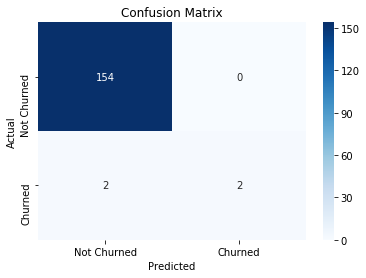

NameError: name 'features_labels' is not defined

In [50]:
# The Logistic Regression model
# model = LogisticRegression(featuresCol='features', labelCol='label')
# Initialize Gradient-Boosting Tree Classifier
model = GBTClassifier(labelCol="label", featuresCol="features", maxIter=2)
pipeline = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, model])

param_grid = ParamGridBuilder() \
    .addGrid(model.maxIter, [10]) \
    .addGrid(model.maxDepth, [2]) \
    .build()

# param_grid = ParamGridBuilder() \
#     .addGrid(model.regParam,[0.01, 0.1]) \
#     .addGrid(model.elasticNetParam,[0.0, 0.5]) \
#     .addGrid(model.aggregationDepth,[2, 5]) \
#     .build()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.aggregationDepth,[2]) \
#     .build()

m = model_fitting(train, pipeline, param_grid, './models/cvModel_gbt.mdl')
# display(get_formated_metrics(m, test))

# Confusion Matrix
pred_train = m.transform(train)
pred_test = m.transform(test)

predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_lr = udfModelEvaluator(predictionAndLabels, "label")

ax= plt.subplot()
sns.heatmap(metricsList_train_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()
